In [ ]:
import re
import numpy as np
import pandas as pd
from pathlib import Path

# 파일 경로 (필요하면 바꾸기)
GT_CANDIDATES  = ["results\week 4_submission.csv", "results\week 4_submission.csv"] # 4주차 정답지 csv 파일 경로
PRED_CANDIDATES= ["test_predictions2.csv", "test_predictions2.csv"] # predict한 csv 파일 경로 

def find_first(path_list):
    for p in path_list:
        if Path(p).exists():
            return p
    raise FileNotFoundError(f"파일이 없습니다: {path_list}")

GT_PATH   = find_first(GT_CANDIDATES)
PRED_PATH = find_first(PRED_CANDIDATES)

GT_PATH, PRED_PATH


('results\\week 4_submission.csv', 'test_predictions2.csv')

CSV 로드 & 공통 컬럼 정렬

In [4]:
# 첫 컬럼(일자 라벨)을 인덱스로 읽기
df_true = pd.read_csv(GT_PATH,   index_col=0)
df_pred = pd.read_csv(PRED_PATH, index_col=0)

# 공통 store_menu_id만 사용 (혹시 열이 다를 수 있으니)
common_cols = sorted(set(df_true.columns) & set(df_pred.columns))
df_true = df_true[common_cols].copy()
df_pred = df_pred[common_cols].copy()

print(df_true.shape, df_pred.shape)
df_true.head(2)


(70, 193) (70, 193)


,느티나무 셀프BBQ_1인 수저세트,느티나무 셀프BBQ_BBQ55(단체),"느티나무 셀프BBQ_대여료 30,000원","느티나무 셀프BBQ_대여료 60,000원","느티나무 셀프BBQ_대여료 90,000원","느티나무 셀프BBQ_본삼겹 (단품,실내)",느티나무 셀프BBQ_스프라이트 (단체),느티나무 셀프BBQ_신라면,느티나무 셀프BBQ_쌈야채세트,느티나무 셀프BBQ_쌈장,...,화담숲주막_스프라이트,화담숲주막_참살이 막걸리,화담숲주막_찹쌀식혜,화담숲주막_콜라,화담숲주막_해물파전,화담숲카페_메밀미숫가루,화담숲카페_아메리카노 HOT,화담숲카페_아메리카노 ICE,화담숲카페_카페라떼 ICE,화담숲카페_현미뻥스크림
﻿영업일자,,,,,,,,,,,,,,,,,,,,,
TEST_00+1일,7,0,3,2,1,2,0,0,1,0,...,8,13,21,3,73,21,8,25,11,12
TEST_00+2일,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Long 포맷으로 변환(+ day_offset 추출)

In [5]:
# 'TEST_00+1일' 같은 라벨에서 1~7 숫자만 추출
def to_day_offset(label: str) -> int:
    m = re.search(r"(\d+)\s*일", str(label))
    return int(m.group(1)) if m else np.nan

true_long = (df_true.reset_index()
             .melt(id_vars=df_true.index.name or "index",
                   var_name="store_menu_id", value_name="y_true")
             .rename(columns={df_true.index.name or "index":"day_label"}))
pred_long = (df_pred.reset_index()
             .melt(id_vars=df_pred.index.name or "index",
                   var_name="store_menu_id", value_name="y_pred")
             .rename(columns={df_pred.index.name or "index":"day_label"}))

true_long["day_offset"] = true_long["day_label"].apply(to_day_offset)
pred_long["day_offset"] = pred_long["day_label"].apply(to_day_offset)

# 결합
eval_df = (true_long
           .merge(pred_long[["store_menu_id","day_label","day_offset","y_pred"]],
                  on=["store_menu_id","day_label","day_offset"], how="inner"))

# 숫자형 보정
eval_df["y_true"] = pd.to_numeric(eval_df["y_true"], errors="coerce")
eval_df["y_pred"] = pd.to_numeric(eval_df["y_pred"], errors="coerce")
eval_df = eval_df.dropna(subset=["y_true","y_pred","day_offset"]).copy()

# 매장 ID 만들기: store_menu_id가 "매장_메뉴" 형식이면 앞부분을 매장으로 사용
if "store_id" not in eval_df.columns:
    eval_df["store"] = eval_df["store_menu_id"].astype(str).str.split("_").str[0]
else:
    eval_df["store"] = eval_df["store_id"]

eval_df.head()


,day_label,store_menu_id,y_true,day_offset,y_pred,store
0,TEST_00+1일,느티나무 셀프BBQ_1인 수저세트,7,1,2.646196,느티나무 셀프BBQ
1,TEST_00+2일,느티나무 셀프BBQ_1인 수저세트,0,2,0.588504,느티나무 셀프BBQ
2,TEST_00+3일,느티나무 셀프BBQ_1인 수저세트,4,3,1.099429,느티나무 셀프BBQ
3,TEST_00+4일,느티나무 셀프BBQ_1인 수저세트,5,4,1.632118,느티나무 셀프BBQ
4,TEST_00+5일,느티나무 셀프BBQ_1인 수저세트,5,5,2.106758,느티나무 셀프BBQ


대회식 sMAPE(ε 없음) 정의 + A=0 제외

In [6]:
def smape_no_eps(a, p):
    a = np.asarray(a, float); p = np.asarray(p, float)
    denom = np.abs(a) + np.abs(p)
    mask = denom > 0
    # 분모 0이면 제외 (a=p=0), 또한 대회는 A=0(실매출=0)도 제외해야 하므로 별도 마스크 추가
    return float(np.mean(2.0 * np.abs(a[mask] - p[mask]) / denom[mask]) * 100)

# 규칙: 실제 매출이 0인 경우는 평가 제외
eval_use = eval_df[eval_df["y_true"] != 0].copy()
len(eval_use), len(eval_df)


(6602, 13510)

대회 공식에 맞춘 집계 (매장→품목→날짜)

In [7]:
# 1) 품목 i(=store_menu_id)별로 날짜 평균 sMAPE 계산
item_smape = (eval_use
              .groupby(["store","store_menu_id"], as_index=False)
              .apply(lambda g: pd.Series({"smape": smape_no_eps(g["y_true"], g["y_pred"])}))
              .reset_index(drop=True))

# 2) 매장별 품목 평균
store_smape = (item_smape
               .groupby("store", as_index=False)["smape"]
               .mean()
               .rename(columns={"smape":"store_smape"}))

# 3) 매장 가중 합(여기선 균등 가중 → 단순 평균)
leader_like_score = float(store_smape["store_smape"].mean())
leader_like_score


C:\Users\kutt9\AppData\Local\Temp\ipykernel_30332\2704529132.py:4: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({"smape": smape_no_eps(g["y_true"], g["y_pred"])}))


88.23063804892558

매장 가중치가 있다면(예: weights.csv에 store,w), 아래처럼 적용:

In [8]:
# (선택) 매장 가중치 적용 예시
# weights = pd.read_csv("store_weights.csv")  # columns: store, w (w 합이 1이 되게 normalize)
# w = store_smape.merge(weights, on="store", how="left").fillna({"w":0.0})
# leader_like_score = float((w["store_smape"] * w["w"]).sum())


참고용: 일자별 sMAPE(ε 없음)도 확인

(튜닝 방향을 보기 위해 — 리더보드 점수와 직접 비교용은 아님)

In [9]:
by_day = (eval_use.groupby("day_offset")
          .apply(lambda g: smape_no_eps(g["y_true"], g["y_pred"]))
          .reset_index(name="SMAPE_no_eps"))
by_day


C:\Users\kutt9\AppData\Local\Temp\ipykernel_30332\397274283.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: smape_no_eps(g["y_true"], g["y_pred"]))


,day_offset,SMAPE_no_eps
0,1,72.441853
1,2,101.440003
2,3,97.093265
3,4,84.637605
4,5,81.937165
5,6,73.065179
6,7,73.497528


출력 요약

In [10]:
print(f"[Leader-like sMAPE] (A=0 제외, ε 없음, 매장-품목-날짜 집계, 매장 균등가중): {leader_like_score:.6f}")
print(f"- 매장 수: {store_smape.shape[0]}, 품목 수: {item_smape['store_menu_id'].nunique()}, 표본 수(행): {len(eval_use)}")
display(store_smape.sort_values('store_smape').head(5))   # 잘 맞는 매장
display(store_smape.sort_values('store_smape').tail(5))   # 어려운 매장
display(by_day)


[Leader-like sMAPE] (A=0 제외, ε 없음, 매장-품목-날짜 집계, 매장 균등가중): 88.230638
- 매장 수: 9, 품목 수: 193, 표본 수(행): 6602


,store,store_smape
7,화담숲주막,70.880885
5,카페테리아,73.084401
2,라그로타,77.303777
8,화담숲카페,79.303905
1,담하,92.209323


,store,store_smape
1,담하,92.209323
3,미라시아,94.633963
6,포레스트릿,95.295647
4,연회장,99.069307
0,느티나무 셀프BBQ,112.294536


,day_offset,SMAPE_no_eps
0,1,72.441853
1,2,101.440003
2,3,97.093265
3,4,84.637605
4,5,81.937165
5,6,73.065179
6,7,73.497528


A — 공통 유틸(지표/스타일)

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from textwrap import shorten

plt.rcParams["figure.dpi"] = 120
plt.rcParams["axes.grid"]  = True

def smape_no_eps(a, p):
    a = np.asarray(a, float); p = np.asarray(p, float)
    denom = np.abs(a) + np.abs(p)
    mask = denom > 0
    return float(np.mean(2.0*np.abs(a[mask]-p[mask]) / denom[mask]) * 100)

# 안전 샘플링
def _sample_df(df, n=20000, seed=42):
    if len(df) <= n:
        return df
    return df.sample(n, random_state=seed)


B — 전체 평균(혹은 중앙값) 겹쳐 그리기

C:\Users\kutt9\AppData\Local\Temp\ipykernel_30332\3604389047.py:9: FutureWarning: The provided callable <function mean at 0x00000199AAEE6E60> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  by_day_true = df.groupby("day_offset")["y_true"].agg([method, "quantile"])
C:\Users\kutt9\AppData\Local\Temp\ipykernel_30332\3604389047.py:10: FutureWarning: The provided callable <function mean at 0x00000199AAEE6E60> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  by_day_pred = df.groupby("day_offset")["y_pred"].agg([method, "quantile"])


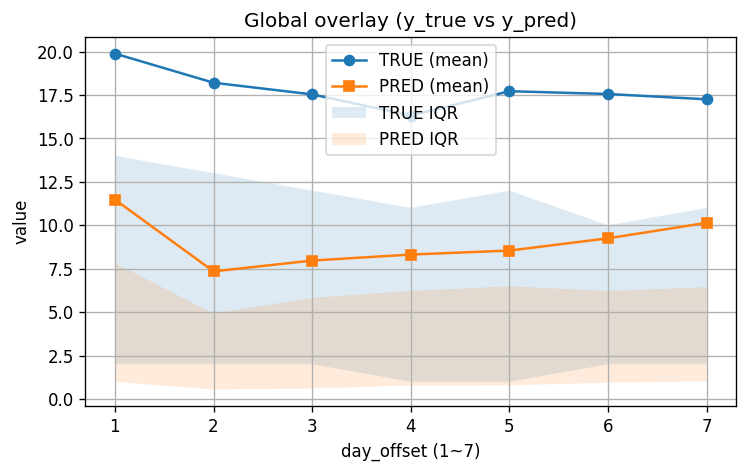

In [13]:
def plot_global_overlay(df, agg="mean", with_band=True, title="Global overlay (y_true vs y_pred)"):
    """
    agg: "mean" or "median"
    with_band: 25~75% 구간을 밴드로 표시
    """
    df = df.copy()
    method = np.mean if agg=="mean" else np.median
    
    by_day_true = df.groupby("day_offset")["y_true"].agg([method, "quantile"])
    by_day_pred = df.groupby("day_offset")["y_pred"].agg([method, "quantile"])

    # 직접 구해주자 (25, 75 percentile)
    qt = df.groupby("day_offset")["y_true"].quantile([0.25, 0.75]).unstack()
    qp = df.groupby("day_offset")["y_pred"].quantile([0.25, 0.75]).unstack()

    x = sorted(df["day_offset"].unique())
    y_true = [method(df.loc[df["day_offset"]==d, "y_true"]) for d in x]
    y_pred = [method(df.loc[df["day_offset"]==d, "y_pred"]) for d in x]

    plt.figure(figsize=(7,4))
    plt.plot(x, y_true, marker="o", label=f"TRUE ({agg})")
    plt.plot(x, y_pred, marker="s", label=f"PRED ({agg})")
    if with_band:
        plt.fill_between(x, qt.loc[x, 0.25], qt.loc[x, 0.75], alpha=0.15, label="TRUE IQR")
        plt.fill_between(x, qp.loc[x, 0.25], qp.loc[x, 0.75], alpha=0.15, label="PRED IQR")
    plt.xticks(x)
    plt.xlabel("day_offset (1~7)")
    plt.ylabel("value")
    plt.title(title)
    plt.legend()
    plt.show()

# 사용 예
plot_global_overlay(eval_use, agg="mean", with_band=True)


C — 산점도(정답 vs 예측) + 대각선

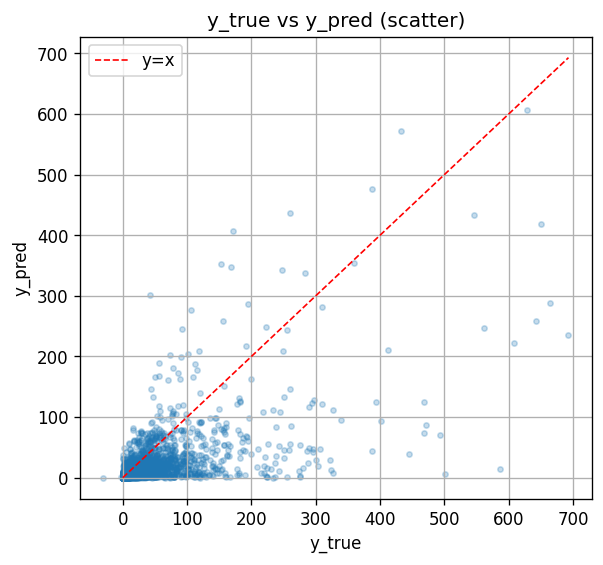

In [14]:
def plot_scatter_true_vs_pred(df, sample=25000, log=False, title="y_true vs y_pred (scatter)"):
    d = _sample_df(df, n=sample)
    plt.figure(figsize=(5.5,5))
    plt.scatter(d["y_true"], d["y_pred"], s=10, alpha=0.25)
    m = max(d["y_true"].max(), d["y_pred"].max())
    plt.plot([0, m], [0, m], "r--", lw=1, label="y=x")
    if log:
        plt.xscale("log"); plt.yscale("log")
        plt.xlabel("y_true (log)"); plt.ylabel("y_pred (log)")
    else:
        plt.xlabel("y_true"); plt.ylabel("y_pred")
    plt.title(title)
    plt.legend()
    plt.show()

# 사용 예
plot_scatter_true_vs_pred(eval_use, sample=30000, log=False)


D — 개별 품목(=store_menu_id) 7일 시계열 겹쳐 그리기

c:\Users\kutt9\OneDrive\바탕 화면\lg-aimers-sales-predictor-main_1\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 45712 (\N{HANGUL SYLLABLE NEU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\kutt9\OneDrive\바탕 화면\lg-aimers-sales-predictor-main_1\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 54000 (\N{HANGUL SYLLABLE TI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\kutt9\OneDrive\바탕 화면\lg-aimers-sales-predictor-main_1\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 45208 (\N{HANGUL SYLLABLE NA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\kutt9\OneDrive\바탕 화면\lg-aimers-sales-predictor-main_1\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 47924 (\N{HANGUL SYLLABLE MU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\kutt9\OneD

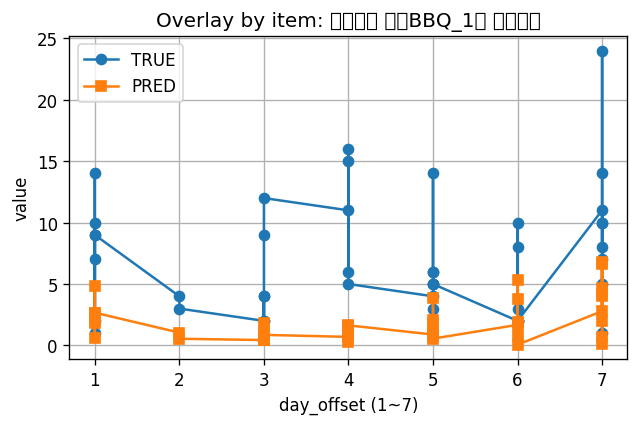

In [15]:
def plot_item_series(df, item_id, title_max_len=40):
    g = df[df["store_menu_id"]==item_id].sort_values("day_offset")
    if g.empty:
        print("해당 store_menu_id가 없습니다:", item_id); return
    x = g["day_offset"].values
    plt.figure(figsize=(6,3.5))
    plt.plot(x, g["y_true"].values, marker="o", label="TRUE")
    plt.plot(x, g["y_pred"].values, marker="s", label="PRED")
    plt.xticks(range(1,8))
    t = shorten(str(item_id), width=title_max_len, placeholder="…")
    plt.title(f"Overlay by item: {t}")
    plt.xlabel("day_offset (1~7)"); plt.ylabel("value")
    plt.legend(); plt.show()

# 사용 예 (하나를 골라서)
some_item = eval_use["store_menu_id"].iloc[0]
plot_item_series(eval_use, some_item)


E — 겹침이 안 되는(오차 큰) Top-K 품목 자동 시각화

C:\Users\kutt9\AppData\Local\Temp\ipykernel_30332\3466718796.py:8: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: f(g))
C:\Users\kutt9\AppData\Local\Temp\ipykernel_30332\3466718796.py:30: UserWarning: Glyph 52852 (\N{HANGUL SYLLABLE KA}) missing from font(s) DejaVu Sans.
  fig.tight_layout()
C:\Users\kutt9\AppData\Local\Temp\ipykernel_30332\3466718796.py:30: UserWarning: Glyph 54168 (\N{HANGUL SYLLABLE PE}) missing from font(s) DejaVu Sans.
  fig.tight_layout()
C:\Users\kutt9\AppData\Local\Temp\ipykernel_30332\3466718796.py:30: UserWarning: Glyph 53580 (\N{HANGUL SYLLABLE TE}) missing from font(s) DejaVu Sans.
  fig.tight_layout()
C:\Users\kutt9\AppData\Local\Temp\ipykernel_30332\34667

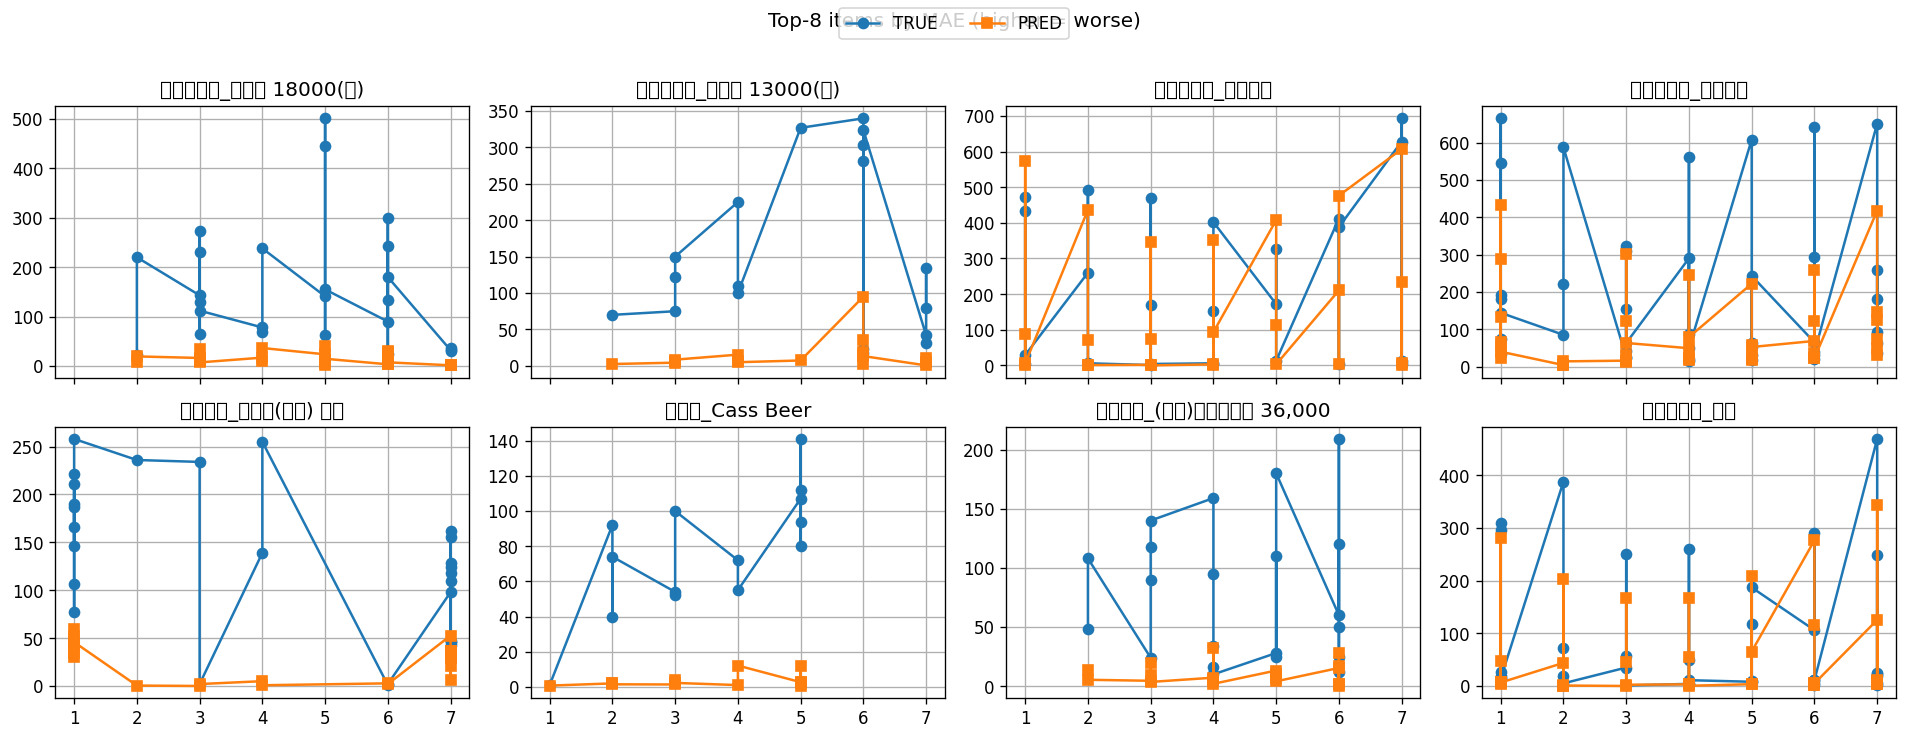

In [16]:
def item_metric(df, metric="SMAPE"):
    f = {
        "SMAPE": lambda g: smape_no_eps(g["y_true"], g["y_pred"]),
        "MAE":   lambda g: float(np.mean(np.abs(g["y_true"] - g["y_pred"]))),
        "RMSE":  lambda g: float(np.sqrt(np.mean((g["y_true"] - g["y_pred"])**2))),
    }[metric.upper()]
    s = (df.groupby("store_menu_id")
         .apply(lambda g: f(g))
         .reset_index(name=metric.upper()))
    return s

def plot_topk_items(df, metric="MAE", topk=8, cols=4):
    scores = item_metric(df, metric=metric).sort_values(metric.upper(), ascending=False).head(topk)
    ids = scores["store_menu_id"].tolist()
    rows = int(np.ceil(topk/cols))
    fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 3*rows), sharex=True)
    axes = np.array(axes).reshape(rows, cols)
    for ax, item_id in zip(axes.ravel(), ids):
        g = df[df["store_menu_id"]==item_id].sort_values("day_offset")
        ax.plot(g["day_offset"], g["y_true"], marker="o", label="TRUE")
        ax.plot(g["day_offset"], g["y_pred"], marker="s", label="PRED")
        ax.set_title(shorten(str(item_id), width=28, placeholder="…"))
        ax.set_xticks(range(1,8))
    # 빈 축 숨김
    for ax in axes.ravel()[len(ids):]:
        ax.axis("off")
    handles, labels = axes.ravel()[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper center", ncols=2)
    fig.suptitle(f"Top-{topk} items by {metric.upper()} (higher = worse)", y=1.02)
    fig.tight_layout()
    plt.show()

# 사용 예
plot_topk_items(eval_use, metric="MAE", topk=8, cols=4)


F — 매장 단위로 합계/평균 겹쳐 그리기

c:\Users\kutt9\OneDrive\바탕 화면\lg-aimers-sales-predictor-main_1\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 45712 (\N{HANGUL SYLLABLE NEU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\kutt9\OneDrive\바탕 화면\lg-aimers-sales-predictor-main_1\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 54000 (\N{HANGUL SYLLABLE TI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\kutt9\OneDrive\바탕 화면\lg-aimers-sales-predictor-main_1\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 45208 (\N{HANGUL SYLLABLE NA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\kutt9\OneDrive\바탕 화면\lg-aimers-sales-predictor-main_1\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 47924 (\N{HANGUL SYLLABLE MU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\kutt9\OneD

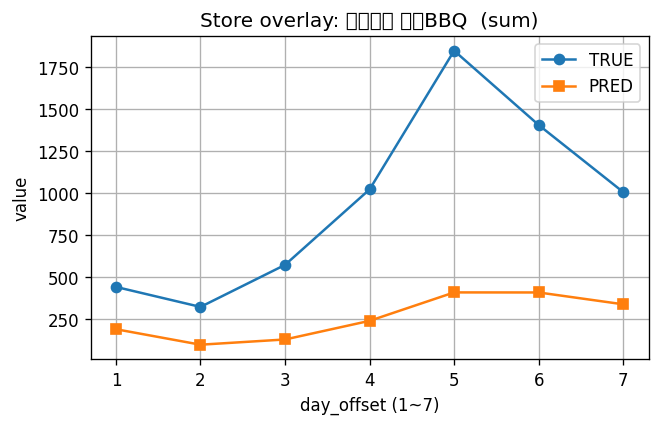

In [17]:
def plot_store_overlay(df, store_id, agg="sum"):
    d = df[df["store"]==store_id]
    if d.empty:
        print("해당 store가 없습니다:", store_id); return
    if agg=="sum":
        g = d.groupby("day_offset")[["y_true","y_pred"]].sum().reset_index()
    else:
        g = d.groupby("day_offset")[["y_true","y_pred"]].mean().reset_index()

    plt.figure(figsize=(6,3.5))
    plt.plot(g["day_offset"], g["y_true"], marker="o", label="TRUE")
    plt.plot(g["day_offset"], g["y_pred"], marker="s", label="PRED")
    plt.xticks(range(1,8))
    plt.title(f"Store overlay: {store_id}  ({agg})")
    plt.xlabel("day_offset (1~7)"); plt.ylabel("value")
    plt.legend(); plt.show()

# 사용 예
some_store = eval_use["store"].iloc[0]
plot_store_overlay(eval_use, some_store, agg="sum")


G — 분포 겹침(정답 vs 예측 히스토그램)

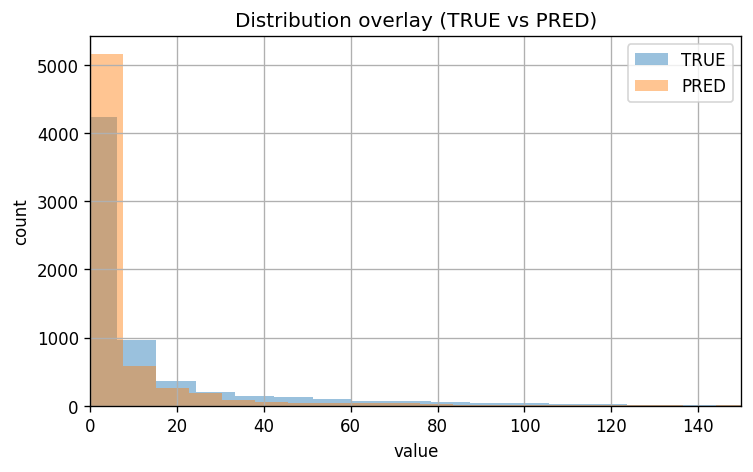

In [18]:
def plot_distribution_overlay(df, bins=60, xlim=None, title="Distribution overlay (TRUE vs PRED)"):
    y_true = df["y_true"].values
    y_pred = df["y_pred"].values
    plt.figure(figsize=(7,4))
    plt.hist(y_true, bins=bins, alpha=0.45, label="TRUE")
    plt.hist(y_pred, bins=bins, alpha=0.45, label="PRED")
    if xlim is not None:
        plt.xlim(*xlim)
    plt.xlabel("value"); plt.ylabel("count")
    plt.title(title)
    plt.legend(); plt.show()

# 사용 예
plot_distribution_overlay(eval_use, bins=80, xlim=(0, 150))
